In [3]:
#pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from math import pi
from math import sqrt
from skimage import morphology
from skimage.morphology import opening
from skimage import transform
from skimage import filters
from skimage.filters import sobel
from PIL import Image

In [7]:
IMG_PATH = '../data/test/example_image/'
SUPER_IMG_PATH = '../data/example_image/'
SEG_PATH = '../data/test/example_segmentation/'

TRUTH = '../data/example_ground_truth.csv'
FEATURES = '../features/features.csv'

In [10]:
def boundaries(image):
    mask = np.where(image == 1)
    left = min(mask[1])
    right = max(mask[1])
    upper = min(mask[0])
    lower = max(mask[0])
    return upper, lower, left, right

def center(image):
    up, dw, lt, rt = boundaries(image)
    center = ((up + dw)//2,(rt + lt)//2)
    return center

(2016, 3024, 3)
uint8
(2016, 3024)


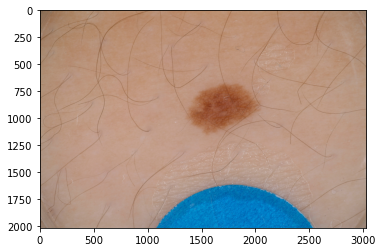

In [19]:
img = plt.imread("../data/example_image/ISIC_0001769.jpg")
mask = plt.imread('../data/example_segmentation/ISIC_0001769_segmentation.png')

print(img.shape)
print(img.dtype)
print(mask.shape)

plt.imshow(img, cmap='gray');

In [20]:
#From TA Camilla
#Measure area: the sum of all white pixels in the mask image

area = np.sum(mask)

#Measure perimeter: first find which pixels belong to the perimeter.

struct_element = morphology.disk(1)
mask_erotion = morphology.binary_erosion(mask, struct_element)
image_perimeter = mask - mask_erotion

#simple
width_max = 0
height_max = 0

for row in image_perimeter:
    result = np.where(row==1)[0]
    if result.size != 0:
        width_diff = result[-1] - result[0]
        if width_diff > width_max:
            width_max = width_diff
            
for col in image_perimeter.transpose():
    result = np.where(col == 1)[0]
    if result.size != 0:
        height_diff = result[-1] - result[0]
        if height_diff > height_max:
            height_max = height_diff


In [21]:
print("width_max:", width_max)
print("height_max:", height_max)

width_max: 654
height_max: 480


In [24]:
print(boundaries(img))
print(center(img))

(1619, 2015, 1087, 2518)
(1817, 1802)
